In [42]:
%%capture
!pip install Bio

In [43]:
%%capture
import csv
import pandas as pd
import numpy as np
import re
import nltk
import string

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from tqdm import tqdm
from functools import reduce
from Bio import Entrez
from pandas.core.internals.construction import dataclasses_to_dicts
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords

In [44]:
Entrez.email = "a.mehraram@campus.unimib.it"

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
data = pd.read_csv('/content/drive/MyDrive/publications.csv')

In [47]:

# def safe_get(dictionary, keys, default=None):
#     return reduce(lambda d, key: d.get(key, default) if isinstance(d, dict) else default, keys.split("."), dictionary)

# def fetch_pubmed_data(query, max_results):
#     handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
#     record = Entrez.read(handle)
#     id_list = record["IdList"]

#     data = []

#     for pubmed_id in id_list:
#         pubmed_record = Entrez.efetch(db="pubmed", id=pubmed_id, retmode="xml")
#         try:
#           record_dict = Entrez.read(pubmed_record)['PubmedArticle'][0]['MedlineCitation']['Article']
#         except:
#           print("index OOR")
#           continue
#         # Extract date and abstract information
#         journal_title = safe_get(record_dict, 'Journal.Title')
#         article_title = safe_get(record_dict, 'ArticleTitle')

#         abstract = safe_get(record_dict,'Abstract.AbstractText')
#         try:
#           abstract = abstract[0]
#           abstract = str(abstract)
#         except:
#           print("is not a list: ", pubmed_id)

#         language = record_dict['Language'][0]

#         try:
#           pub_date = record_dict['ArticleDate'][0]
#           year = safe_get(pub_date,'Year')
#           month = safe_get(pub_date,'Month')
#           day = safe_get(pub_date,'Day')
#           pub_date = f'{year}-{month}-{day}'
#         except:
#           try:
#             pub_date = record_dict['ArticleDate'][0]
#             year = safe_get(pub_date,'Year')
#             pub_date = f'{year}-01-01'
#           except:
#             pub_date = "1970-01-01"


#         data.append({"PubmedID": pubmed_id, "ArticleTitle":article_title ,"PubDate": pub_date, "Abstract": abstract, "Language": language})
#     return data

In [48]:
# data = fetch_pubmed_data("Parkinson's OR Parkinson) AND (drawing OR draw)", 100000)

# header = ["PubmedID", "ArticleTitle", "PubDate", "Abstract", "Language"]
# with open('/content/drive/MyDrive/publications.csv', 'w') as file:
#     writer = csv.DictWriter(file, fieldnames=header)
#     writer.writeheader()
#     for row in data:
#         writer.writerow(row)


In [131]:
df = pd.DataFrame(data)

In [50]:
# def fetch_pubdate(pubmed_id):
#     try:
#         handle = Entrez.esummary(db="pubmed", id=pubmed_id)
#         record = Entrez.read(handle)
#         handle.close()
#         return record[0]["PubDate"]
#     except Exception as e:
#         print(f"Error fetching data for {pubmed_id}: {e}")
#         return None  # or some default value

# # Apply the function to the 'PubmedID' column and assign the results to the 'date' column
# df['date'] = df['PubmedID'].apply(fetch_pubdate)
# df.to_csv('/content/drive/MyDrive/publications.csv')

In [51]:
df.isnull().sum()

Unnamed: 0      0
PubmedID        0
ArticleTitle    0
PubDate         0
Abstract        8
Language        0
date            0
dtype: int64

In [115]:
df=df.dropna()

Preprocessing

In [53]:
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP
from io import BytesIO
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
stop_words.update(['from', 'subject', 're', 'edu', 'use', 'pd', 's', 'however', 'ad', 'et', 'also', 'may', 'non'])

In [54]:
def remove_whitespaces(text):
  return text.replace(" ", "").replace("\t", "").replace("\n", "")

def remove_numbers(text):
  return re.sub('[0-9]+', '', text)

def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in stop_words])
  # return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

PUNCTUATIONS = string.punctuation.replace('#','').replace('@','')#tweets special chrs

def remove_punctuation(text):
    trans = str.maketrans(dict.fromkeys(PUNCTUATIONS, ' '))
    return text.translate(trans)

def tokenizer(text):
  tokenized_text = nltk.word_tokenize(text)
  return tokenized_text

def lemmaSentence(token_words):
    lemma_text=[]
    for word in token_words:
        lemma_text.append(wordnet_lemmatizer.lemmatize(word))
    return lemma_text

In [116]:
df["preprocessed_text"] = df["Abstract"].str.lower()
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda text: remove_numbers(text))
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda text: remove_punctuation(text))
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda text: remove_stopwords(text))
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda text: tokenizer(text))
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda words: list(nltk.bigrams(words)))
df["preprocessed_text"] = df["preprocessed_text"].apply(lambda bigrams: [wordnet_lemmatizer.lemmatize(word) for bigram in bigrams for word in bigram])

In [117]:
df["preprocessed_text"].head(4)

0    [parkinson, disease, disease, cognitive, cogni...
1    [abnormal, accumulation, accumulation, lipid, ...
2    [point, mutation, mutation, leucine, leucine, ...
3    [directed, acyclic, acyclic, graph, graph, dag...
Name: preprocessed_text, dtype: object

Scegliamo la lemmatization in quanto e un metodo piu accurato.

##Topic Modeling: LDA

In [57]:
%%capture
!pip install pyLDAvis

In [58]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

In [118]:
X = df.preprocessed_text

In [60]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def create_dictionary(words):
    return Dictionary(words)
texts = list(sent_to_words(X))
dictionary = create_dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
       corpus.append(id2word.doc2bow(text))
    return corpus

In [119]:
corpus=create_document_matrix(texts,dictionary)
print(texts[1])
print(corpus[1])

['abnormal', 'accumulation', 'accumulation', 'lipids', 'lipids', 'found', 'found', 'dopamine', 'dopamine', 'neurons', 'neurons', 'resident', 'resident', 'microglia', 'microglia', 'substantia', 'substantia', 'nigra', 'nigra', 'patients', 'patients', 'parkinson', 'parkinson', 'disease', 'disease', 'accumulation', 'accumulation', 'lipids', 'lipids', 'important', 'important', 'risk', 'risk', 'factor', 'factor', 'previous', 'previous', 'studies', 'studies', 'mainly', 'mainly', 'focussed', 'focussed', 'lipid', 'lipid', 'metabolism', 'metabolism', 'peripheral', 'peripheral', 'blood', 'blood', 'little', 'little', 'attention', 'attention', 'given', 'given', 'cerebrospinal', 'cerebrospinal', 'fluid', 'fluid', 'csf', 'csf', 'drew', 'drew', 'lipidomic', 'lipidomic', 'signature', 'signature', 'csf', 'csf', 'patients', 'patients', 'evaluated', 'evaluated', 'role', 'role', 'lipids', 'lipids', 'csf', 'csf', 'biomarkers', 'biomarkers', 'diagnosis']
[(14, 1), (15, 4), (16, 2), (17, 2), (18, 2), (19, 2),

In [120]:
list_topic_number = []
for i in range(2, 20):
  lda_model = gensim.models.LdaModel(corpus,
                                   id2word=dictionary,
                                   num_topics=i,
                                   random_state=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  list_topic_number.append(coherence_lda)

In [121]:
coherence_df = pd.DataFrame({'topic_n': list(range(2, 20)), 'coherence': list_topic_number})
optimal_coherence = coherence_df.coherence.max()
optimal_topic_n = coherence_df[coherence_df.coherence == optimal_coherence]
print('the topic number with the highest coherence is: ', optimal_coherence, 'for n Topic = ', optimal_topic_n.topic_n)

the topic number with the highest coherence is:  0.4802522782555423 for n Topic =  1    3
Name: topic_n, dtype: int64


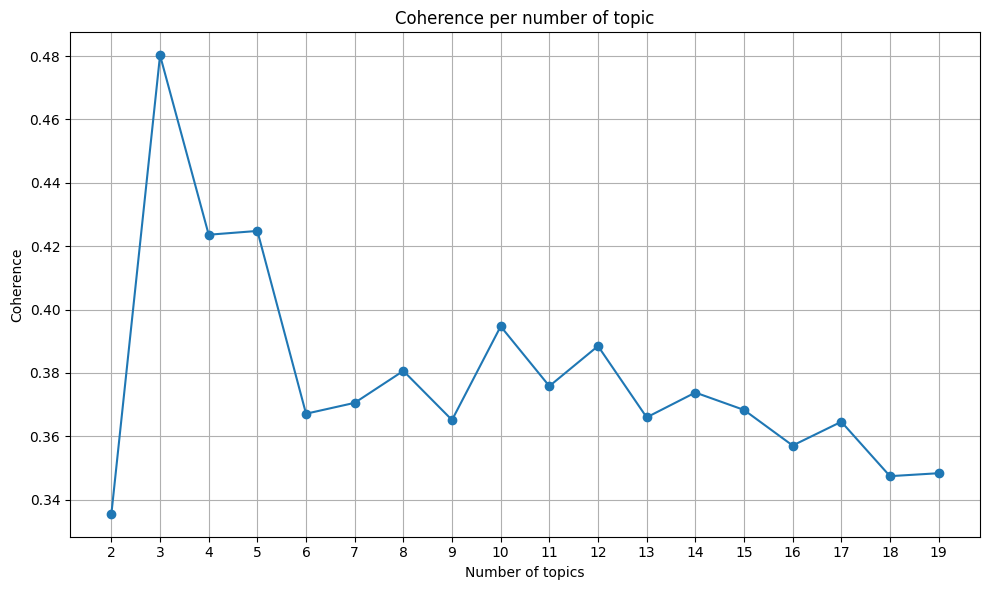

In [122]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(coherence_df.topic_n, coherence_df.coherence, marker='o', linestyle='-')

# Adjust xticks to only have integer values
plt.xticks(coherence_df.topic_n)

# Titles and labels
plt.title('Coherence per number of topic')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')

plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
lda_model = gensim.models.LdaModel(corpus,
                                   id2word=dictionary,
                                   num_topics=optimal_topic_n.topic_n,
                                   random_state=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

In [124]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.022*"cognitive" + 0.015*"dementia" + 0.013*"test" + 0.011*"drawing" + '
  '0.009*"impairment" + 0.008*"study" + 0.006*"sup" + 0.006*"clock" + '
  '0.006*"treatment" + 0.005*"performance"'),
 (1,
  '0.014*"motor" + 0.014*"tremor" + 0.012*"drawing" + 0.009*"movement" + '
  '0.007*"study" + 0.007*"clinical" + 0.006*"control" + 0.006*"task" + '
  '0.006*"movements" + 0.006*"controls"'),
 (2,
  '0.008*"clinical" + 0.008*"studies" + 0.007*"disorders" + 0.007*"draw" + '
  '0.007*"diseases" + 0.006*"review" + 0.006*"brain" + 0.005*"research" + '
  '0.004*"attention" + 0.004*"effects"')]


In [84]:
%%capture
!pip install "pandas<2.0.0"

In [125]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008459  0.132925       1        1  44.945095
1      0.081302 -0.066437       2        1  30.816192
0     -0.089761 -0.066488       3        1  24.238713, topic_info=            Term        Freq       Total Category  logprob  loglift
1      cognitive  681.000000  681.000000  Default  30.0000  30.0000
698       tremor  465.000000  465.000000  Default  29.0000  29.0000
3       dementia  477.000000  477.000000  Default  28.0000  28.0000
231         test  446.000000  446.000000  Default  27.0000  27.0000
7     impairment  320.000000  320.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
161  significant   96.181090  241.546386   Topic3  -5.5846   0.4964
109         used  100.483783  346.590786   Topic3  -5.5408   0.1791
187     clinical  101.628944  706.297902   Topic3  -5.5295  -0.5215
223      results   97.188813  338.148649   Topic3  -5.5742   0.1704
147        motor   97.634010  731.753199   Topic3  -5.5696  -0.5970

[250 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
175       1  0.018937  abilities
175       2  0.056811  abilities
175       3  0.927919  abilities
2133      1  0.986177      abuse
2133      2  0.021439      abuse
...     ...       ...        ...
524       2  0.234234       well
524       3  0.162946       well
1444      1  0.015738    writing
1444      2  0.897067    writing
1444      3  0.078690    writing

[493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [128]:
pyLDAvis.save_html(vis, '3topics.html')

In [126]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.089963246866957


##Analisi statistica sulla letteratura

In [ ]:
df['year'] = df['date'].str.slice(0, 4)
df_2 = df[['PubmedID', 'year']]
df_3 = df_2.groupby(df_2.year, group_keys=False).count()
df_3

In [108]:
import numpy as np
from google.colab import autoviz
import matplotlib.pyplot as plt

def value_plot(df, y, figscale=1, y_label=None):
    df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale))
    plt.gca().spines[['top', 'right']].set_visible(False)
    if y_label:
        plt.ylabel(y_label)
    plt.tight_layout()
    return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3, *['PubmedID'], **{'y_label': 'N of pubs'})
chart


In [109]:
df_2 = df[['PubmedID', 'Language']]
df_3 = df_2.groupby(df_2.Language, group_keys=False).count()

In [111]:
import numpy as np
from google.colab import autoviz
import matplotlib.pyplot as plt

def value_plot(df, y, figscale=1, y_label=None):
    df[y].plot(kind='bar', figsize=(8 * figscale, 4 * figscale))
    plt.gca().spines[['top', 'right']].set_visible(False)
    if y_label:
        plt.ylabel(y_label)
    plt.tight_layout()
    return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3, *['PubmedID'], **{'y_label': 'N of pubs'})
chart


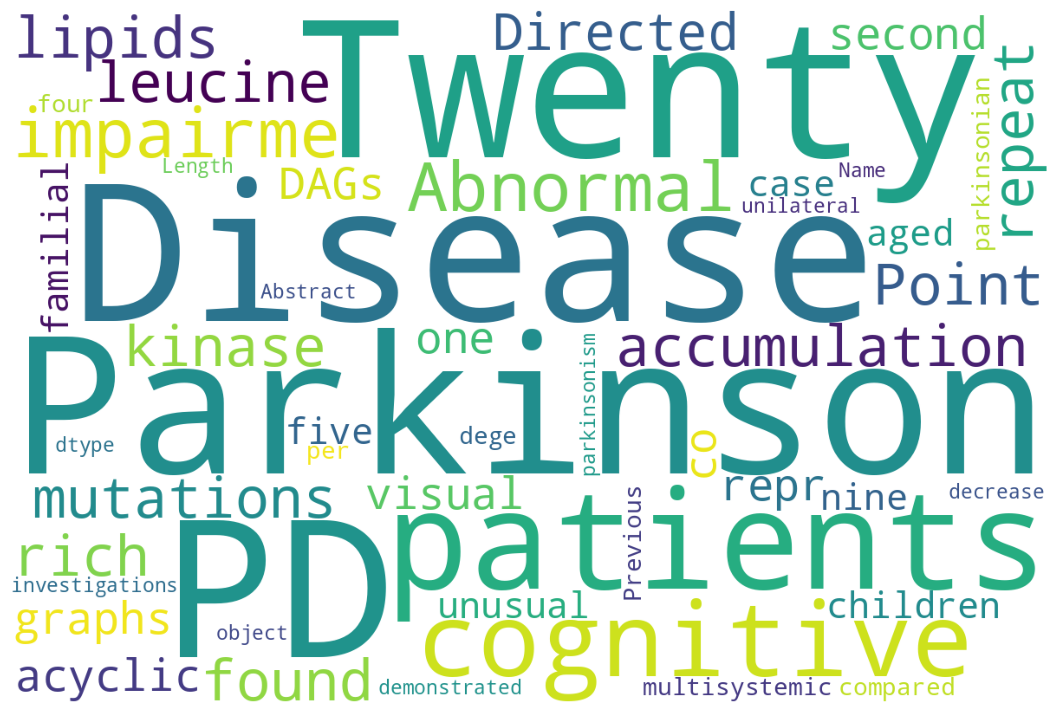

In [95]:
wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100, width = 1200, height = 800).generate(str(df['Abstract']))

plt.rcParams['figure.figsize'] = (16, 9)

print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


In [96]:
text_list = ['thickness', 'mean thickness', 'standard deviation', 'endpoints', 'branch endpoints', 'avarage segment length', 'total skeleton length', 'intersection density', 'enpoint density', 'intersection to endpoint ratio', 'avarage intersection distance', 'avarage grey intensity', 'grey standard deviation', 'entropy', 'glcm features', 'avarage curvature', 'curvature change']

def count_occurrences(text, dataframe):
    return dataframe['Abstract'].str.lower().str.count(r'\b' + text + r'\b').sum()

# Count occurrences for each text
counts = [count_occurrences(text, df) for text in text_list]


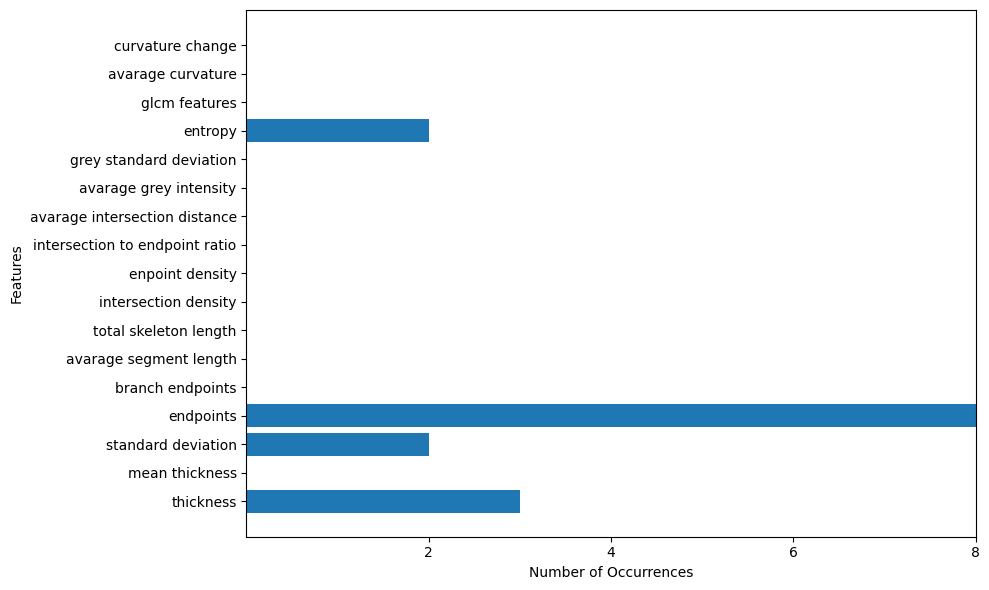

In [145]:
plt.figure(figsize=(10,6))
plt.barh(text_list, counts, align='center')
plt.xlabel('Number of Occurrences')
plt.ylabel('Features')
#plt.title('Occurrences of features in Abstracts')

# Adjust y tick labels to be horizontal
plt.yticks(text_list, text_list, rotation=0)

# Set the x-axis ticks
plt.xticks([2, 4, 6, 8,10])
# Set the x-axis limits
max_count = max(counts)
plt.xlim(0, max_count)  # Extending the range slightly (10% in this example)

plt.tight_layout()  # To ensure everything fits nicely
plt.show()
